In [1]:
import pandas as pd
import numpy as np
from googletrans import Translator
import string
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import json
import numbers
import multiprocessing
from itertools import product
from collections import Counter
RND_STATE = 515991

%matplotlib inline

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 0. Config

In [2]:
max_string_length = 500
translate_delay = 0
translate_chunk = 1000
input_csv = '123.csv'
output_csv = 'data_converted.csv'

In [3]:
def log_progress(sequence, every=None, size=None, name='Processed'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

## 1. Loading data

### 1.1 Loading and decoding data

In [ ]:
data = pd.read_csv(input_csv, sep=',', encoding='utf8')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data_length_start = len(data)
print('Initial length: {0}'.format(data_length_start))
data.describe()

## 2. Preprocessing

### 2.1 Removing nans and unnecessary columns

In [ ]:
data = data.drop(['picture', 'link', 'from_id', 'post_id'], axis=1)
data[['shares']] = data[['shares']].fillna(value=0)
data = data.dropna(how='all')
data = data.dropna(subset=['message'])
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))

### 2.2 Removing emojis, links and numbers

emojis

In [ ]:
data['message'] = data['message'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')
data['description'] = data['description'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')

links

In [ ]:
data['message'] = data['message'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '')
data['description'] = data['description'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '')

numbers

In [ ]:
data['message'] = data['message'].str.replace(r'\b\d+\b','')
data['description'] = data['description'].str.replace(r'\b\d+\b','')

special chars

In [ ]:
data['message'] = data['message'].str.replace('"', '')
data['message'] = data['message'].str.replace('#', '')

data['description'] = data['description'].str.replace('"', '')
data['description'] = data['description'].str.replace('#', '')

### 2.3 Removing advertisements

In [ ]:
data = data[~data['from'].str.contains("Visit-Petersburg", na=False)]
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))
data.describe()

### 2.4 Stripping texts and converting types

In [ ]:
def convert_column_int(column):
    converted = []
    for value in column.values:
        if str(value).isdigit():
            converted.append(value)
        else:
            converted.append(0)
    return converted

In [ ]:
data['message'] = data['message'].apply(lambda x: x[:max_string_length].strip())
data['description'] = data['description'].apply(lambda x: str(x)[:max_string_length].strip())

In [ ]:
data['shares'] = convert_column_int(data['shares'])
data[['shares']] = data[['shares']].apply(pd.to_numeric)

### 2.5 Translating texts into english

In [ ]:
def translate_big_text(texts_source, dest = 'en', chunk_size = 500, delay=0):
    translated = []
    chunks_list = list(chunks(texts_source, chunk_size))
    number_of_errors = 0
    for chunk in log_progress(chunks_list):
        # renew translator
        Translator().translate(u''.join('Hello!'), dest=dest).text
        trans_res, err_num = translate_big_text_internal(chunk)
        number_of_errors += err_num
        translated.extend(trans_res) 
        if delay > 0:
            print('Waiting {0} sec'.format(delay))
            time.sleep(delay)
            
    print('Number of errors: ', number_of_errors)
    return translated

In [ ]:
def translate(text, dest='en'):
    translator = Translator()
    translated = ''
    try:
        translated = translator.translate(u''.join(text), dest=dest).text
    except Exception as e:
        print(e)
    return translated

In [ ]:
def translate_big_text_internal(texts_source, dest='en'):
    with multiprocessing.Pool(processes=30) as pool:
        results = pool.starmap(translate, product(texts_source))
        
    return results, results.count('')

In [ ]:
msg_translations = translate_big_text(data['message'].values, chunk_size = translate_chunk, delay = translate_delay)

In [ ]:
data['message'] = msg_translations

In [ ]:
descr_translations = translate_big_text(data['description'].values, chunk_size = translate_chunk, delay = translate_delay)

In [ ]:
data['description'] = descr_translations

In [ ]:
names_translations = translate_big_text(data['from'].values, chunk_size = translate_chunk, delay = translate_delay)

In [ ]:
data['from'] = names_translations

## 2.7 Moving all words to lower case

In [ ]:
data["message"] = data["message"].map(lambda x: x if type(x)!=str else x.lower())
data["description"] = data["description"].map(lambda x: x if type(x)!=str else x.lower())

### 2.8 Tokenizing sentences

In [ ]:
data['message'] = data['message'].apply(lambda x: nltk.word_tokenize(str(x)))
data['description'] = data['description'].apply(lambda x: nltk.word_tokenize(str(x)))

### 2.9 Removing stopwords and punctuation

In [8]:
stop_words = stopwords.words('english')
stop_words += (['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '\n', '/n', '-', '#', 'visitpetersburg', 'visitrussia', 'russia', 'the', 'is', 'a'])

In [ ]:
data['message'] = data['message'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))
data['description'] = data['description'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))

In [ ]:
data['message'] = data['message'].apply(lambda x: " ".join(x))
data['description'] = data['description'].apply(lambda x: " ".join(x))

### 2.10 Saving data to file

In [5]:
def save_csv():
    data.to_csv(output_csv, index=False)

In [6]:
def parse_csv(series):
    values = series.values
    parsed = []
    for value in values:
        parsed.append(json.loads(value.replace("'",'"')))
    return parsed

In [7]:
def load_csv():
    loaded_data = pd.read_csv(output_csv, sep=',', encoding='utf8')
    loaded_data['message_sentiment_vader'] = parse_csv(loaded_data['message_sentiment_vader'])
    loaded_data['description_sentiment_vader'] = parse_csv(loaded_data['description_sentiment_vader'])
    return loaded_data

In [ ]:
save_csv()

# 3. Processing data

## 3.1 Trying to guess gender by name

In [ ]:
detector = gender.Detector(case_sensitive=False)

In [ ]:
data['from_gender'] = [detector.get_gender((str(name)).split(' ')[0]) for name in data['from'].values]

In [ ]:
data['from_gender'].replace([0],['unknown'],inplace=True)

## 3.1 Getting sentiments by Vader algorithm

In [ ]:
sid = SentimentIntensityAnalyzer()
message_sent = []
descr_sent = []
data['message'].apply(lambda x: message_sent.append(sid.polarity_scores((x))));
data['description'].apply(lambda x: descr_sent.append(sid.polarity_scores((x))));
data['message_sentiment_vader'] = message_sent
data['description_sentiment_vader'] = descr_sent

In [15]:
def get_message_sentiment(series, border_line=0.2):
    values = series.values
    parsed_values = []
    for value in values:
        if value['neg'] >= border_line:
            parsed_values.append('negative')
        elif value['pos'] >= border_line:
            parsed_values.append('positive')
        else:
            parsed_values.append('neutral')
    return parsed_values

In [ ]:
data['message_sentiment_vader_parsed'] = get_message_sentiment(data['message_sentiment_vader'])
data['description_sentiment_vader_parsed'] = get_message_sentiment(data['description_sentiment_vader'])

In [ ]:
save_csv()

## 3.2 Plotting stats 

In [90]:
data = load_csv()

### 3.2.1 Shares per gender

In [17]:
data.groupby(['from_gender']).sum()

,shares
from_gender,
andy,1
female,2166
male,6877
mostly_female,0
mostly_male,512
unknown,227183


#### 3.2.1.1 Row data

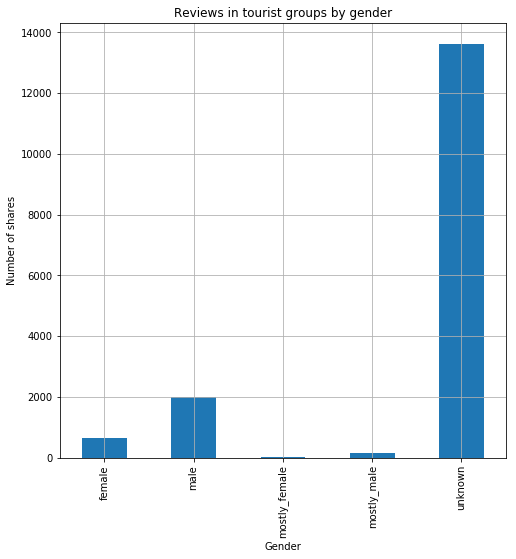

In [18]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy'], axis=0)
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of shares');

#### 3.2.1.2 Only genders

In [19]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy', 'unknown'], axis=0)
groups['female'] += groups['mostly_female']
groups['male'] += groups['mostly_male']
groups = groups.drop(['mostly_female', 'mostly_male'], axis=0)

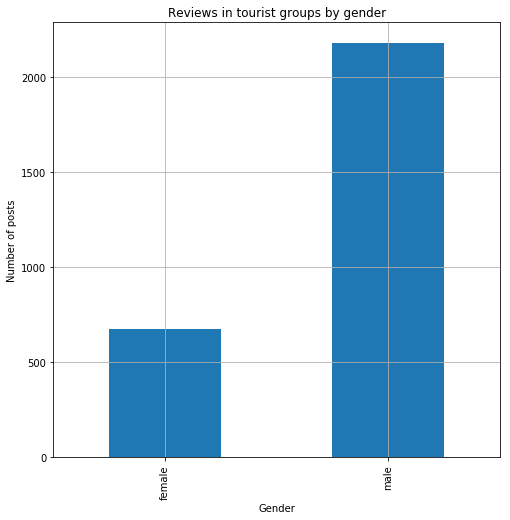

In [20]:
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of posts');

### 3.2.2 Messages sentiments

#### 3.2.2.1 Just sentiments

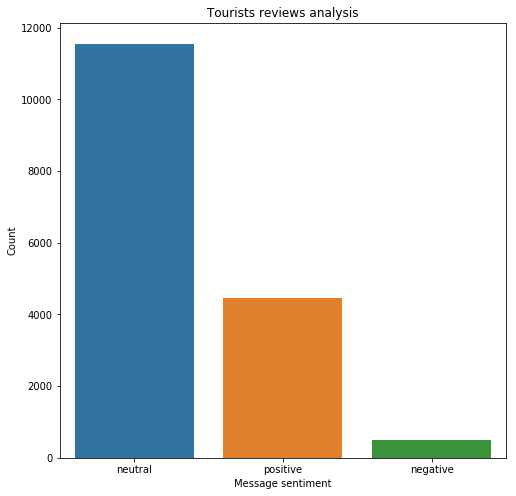

In [21]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x = data['message_sentiment_vader_parsed'])
ax.set_title('Tourists reviews analysis')
ax.set_xlabel('Message sentiment')
ax.set_ylabel('Count')
plt.show()

#### 3.2.2.2 Sentiments multiplied to shares

In [22]:
groups = data.groupby(['message_sentiment_vader_parsed']).size()
neg_shares = np.sum(data[data['message_sentiment_vader_parsed'] == 'negative']['shares'])
neu_shares = np.sum(data[data['message_sentiment_vader_parsed'] == 'neutral']['shares'])
neu_shares = np.sum(data[data['message_sentiment_vader_parsed'] == 'positive']['shares'])

groups['negative'] *= neg_shares
groups['neutral'] *= neu_shares
groups['positive'] *= neu_shares

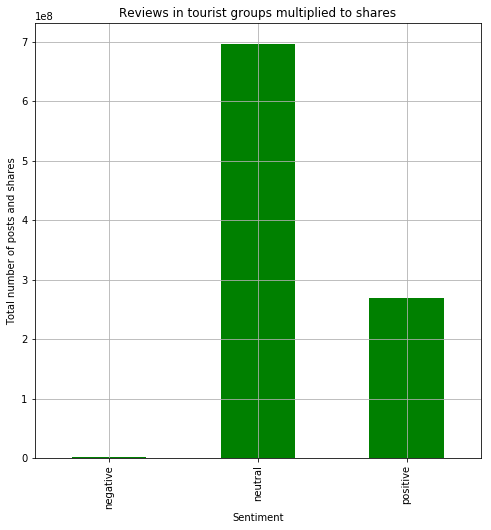

In [23]:
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups multiplied to shares', figsize=(8, 8), color='green')
ax.set_xlabel('Sentiment');
ax.set_ylabel('Total number of posts and shares');

#### 3.2.2.3 Sentiments by gender

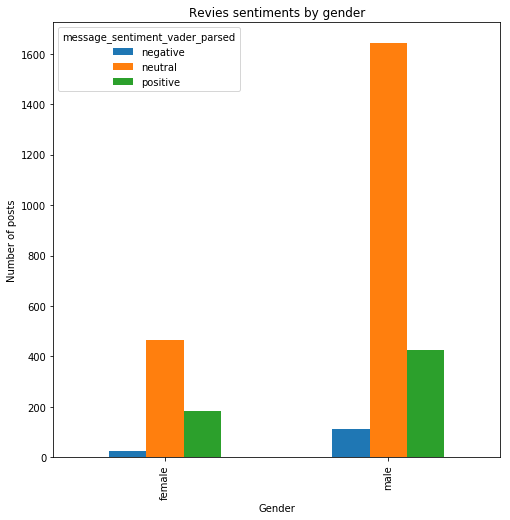

In [24]:
data_tmp = data.copy()
data_tmp = data_tmp.replace({"from_gender": {'mostly_female': 'female', 'mostly_male': 'male', 'andy': 'unknown'}})
data_tmp = data_tmp[data_tmp['from_gender'] != 'unknown']
ax = pd.crosstab(data_tmp['from_gender'], 
                 data_tmp['message_sentiment_vader_parsed']).plot.bar(title = 'Revies sentiments by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of posts');

### 3.2.3 Words

#### 3.2.3.1 Most common words

In [25]:
all_strings = " ".join(map(str, data['message'].values)) + " ".join(map(str, data['description'].values))
all_words = nltk.word_tokenize(all_strings)
stop_words += (['/', "'s", "''", '...', '..', '''``''', '//', '.-', '–', '&', '$', '%', '’', '--', '@'])
all_words = list(filter(lambda y: y not in stop_words, all_words))
counted_words = pd.DataFrame(Counter(all_words).most_common(), columns=['word', 'count'])

In [26]:
counted_words.head(25)[1:]

,word,count
1,yakutia,2341
2,russian,2302
3,moscow,2023
4,petersburg,1941
5,st.,1711
6,kaliningrad,1298
7,yakutsk,1288
8,year,1287
9,tour,1208
10,photo,1177


Plot

In [27]:
top25 = counted_words.head(25)[1:]

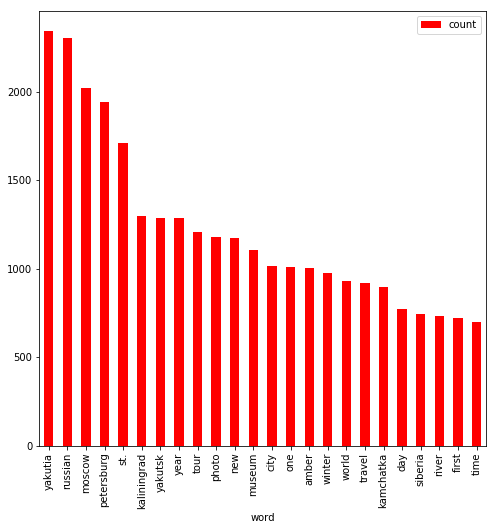

In [28]:
top25.plot.bar(x='word', y='count', figsize=(8, 8), color='red')

#### 3.2.3.2 Most common  words by sentiment

In [29]:
counted_words_sent = counted_words.copy()

In [30]:
sid = SentimentIntensityAnalyzer()

In [31]:
sentiments = []
counted_words_sent['word'].apply(lambda x: sentiments.append(sid.polarity_scores((x))));
counted_words_sent['word_tmp'] = sentiments
counted_words_sent['sentiment'] = get_message_sentiment(counted_words_sent['word_tmp'])
counted_words_sent = counted_words_sent.drop(['word_tmp'], axis=1)

Negative

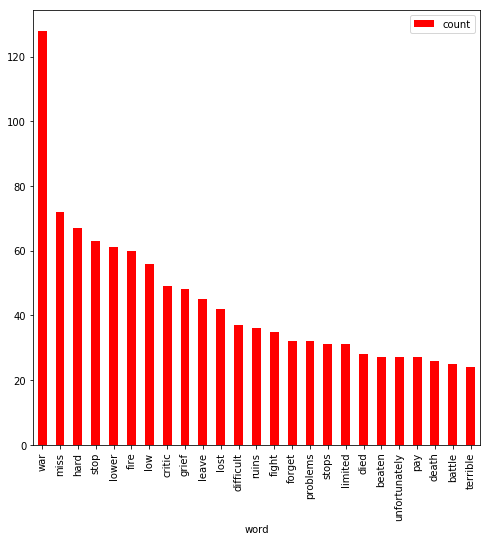

In [32]:
negative = counted_words_sent[counted_words_sent['sentiment'] == 'negative'].head(25)
negative.plot.bar(x='word', y='count', figsize=(8, 8), color='red')

In [33]:
negative

,word,count,sentiment
337,war,128,negative
627,miss,72,negative
682,hard,67,negative
720,stop,63,negative
755,lower,61,negative
763,fire,60,negative
821,low,56,negative
969,critic,49,negative
990,grief,48,negative
1023,leave,45,negative


Positive

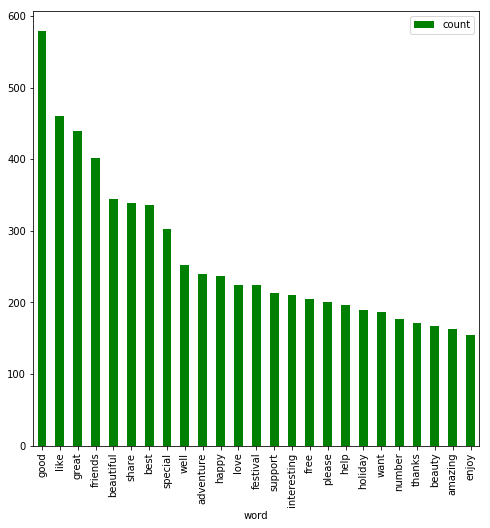

In [34]:
positive = counted_words_sent[counted_words_sent['sentiment'] == 'positive'].head(25)
positive.plot.bar(x='word', y='count', figsize=(8, 8), color='green')

In [35]:
positive

,word,count,sentiment
29,good,579,positive
44,like,461,positive
52,great,440,positive
55,friends,402,positive
67,beautiful,344,positive
71,share,339,positive
72,best,336,positive
86,special,303,positive
124,well,252,positive
134,adventure,240,positive


#### 3.2.3.2 Most common words by city

In [36]:
def filter_by_city(data_df, city):
    return data_tmp[data_df['message'].str.contains(city)==True]

In [37]:
def plot_city(data_df, city):
    data = data_df.copy()
    filteted = filter_by_city(data, city)
    words = nltk.word_tokenize(''.join(filteted['message'].values))
    counted_words = pd.DataFrame(Counter(words).most_common(), columns=['word', 'count'])
    sentiments = []
    
    counted_words['word'].apply(lambda x: sentiments.append(sid.polarity_scores((x))));
    counted_words['word_tmp'] = sentiments
    counted_words['sentiment'] = get_message_sentiment(counted_words['word_tmp'])
    counted_words = counted_words.drop(['word_tmp'], axis=1)
    
    negative = counted_words[counted_words['sentiment'] == 'negative'].head(25)
    negative.plot.bar(x='word', y='count', figsize=(8, 8), color='red')
    
    print('NEGATIVE\n')
    print(negative)
    
    positive = counted_words[counted_words['sentiment'] == 'positive'].head(25)
    positive.plot.bar(x='word', y='count', figsize=(8, 8), color='green')
    
    print('\nPOSITIVE\n')
    print(positive)

#### Yakutia

In [47]:
plot_city(data, 'yakutia')

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


TypeError: Empty 'DataFrame': no numeric data to plot

#### Moscow

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NEGATIVE

             word  count sentiment
121           war      3  negative
200     weakening      2  negative
440     exhausted      1  negative
451          fire      1  negative
480          hide      1  negative
510         gloom      1  negative
529          miss      1  negative
578  disappointed      1  negative
611         stops      1  negative
627      fighting      1  negative
644        battle      1  negative
671           pay      1  negative
807        demand      1  negative
987        graves      1  negative
992     difficult      1  negative

POSITIVE

          word  count sentiment
9        great     10  positive
37       enjoy      5  positive
39    festival      5  positive
40     holiday      5  positive
45        free      4  positive
47    creation      4  positive
52      energy      4  positive
68     festive      4  positive
72     special      4  positive
86        good      3  positive
98        kind      3  positive
108    awarded      3  positive
114

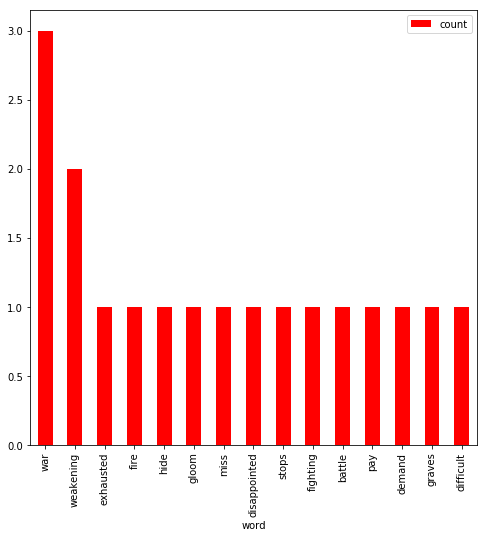

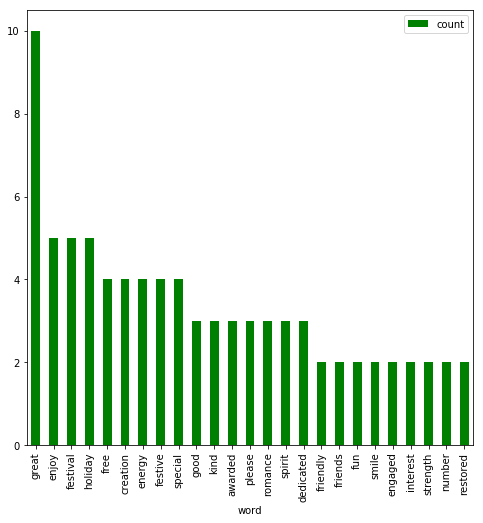

In [41]:
plot_city(data, 'moscow')

#### Petersburg

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NEGATIVE

              word  count sentiment
204          gloom      1  negative
328          stops      1  negative
379  unfortunately      1  negative
383           warn      1  negative
396  inconvenience      1  negative
417            low      1  negative
438      stupidity      1  negative
439          crazy      1  negative
440         stupid      1  negative
443           poor      1  negative
488         demand      1  negative
561   disappointed      1  negative

POSITIVE

          word  count sentiment
7       please      9  positive
14        like      6  positive
15     holiday      6  positive
23       enjoy      5  positive
26        love      4  positive
31        free      4  positive
32     special      4  positive
50     romance      3  positive
51      spirit      3  positive
72       liked      2  positive
75    friendly      2  positive
78        best      2  positive
81     awarded      2  positive
82     friends      2  positive
87        well      2  positive

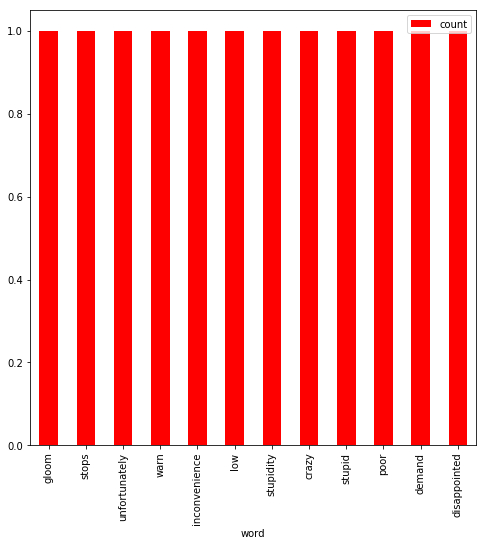

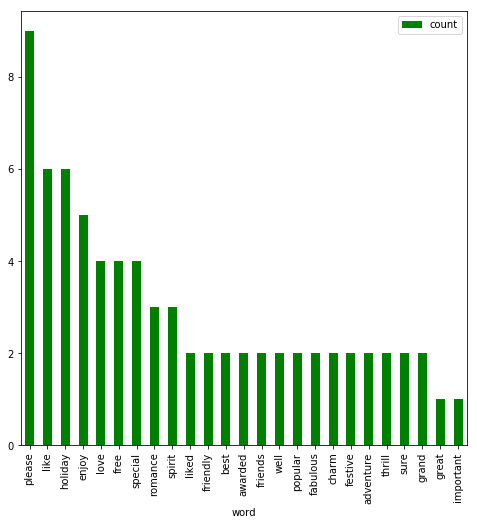

In [42]:
plot_city(data, 'petersburg')

#### Kaliningrad

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NEGATIVE

               word  count sentiment
41            ruins     12  negative
221           sorry      4  negative
225   unfortunately      4  negative
257             war      4  negative
371       collapses      3  negative
374             sad      3  negative
375            lost      3  negative
380         sadness      3  negative
382           alone      3  negative
403            ruin      2  negative
529  contradictions      2  negative
560        suffered      2  negative
565        fighters      2  negative
609          rotten      2  negative
619            dead      2  negative
770      contradict      2  negative
796          fought      2  negative
800       repressed      2  negative
812           crude      2  negative
813          fallen      2  negative
818            drop      2  negative
896        terrible      2  negative
925       perverted      2  negative
954            dull      2  negative
957            ugly      2  negative

POSITIVE

            word 

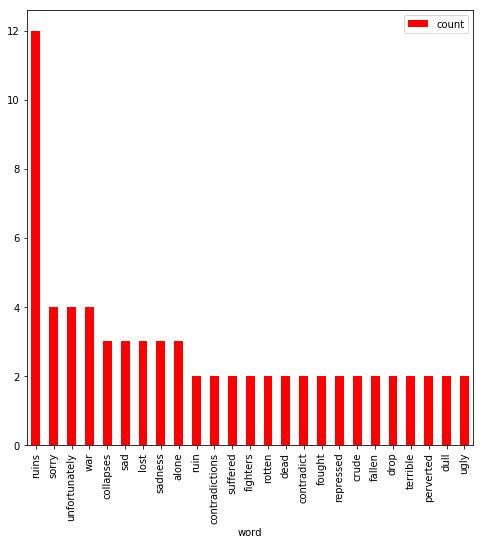

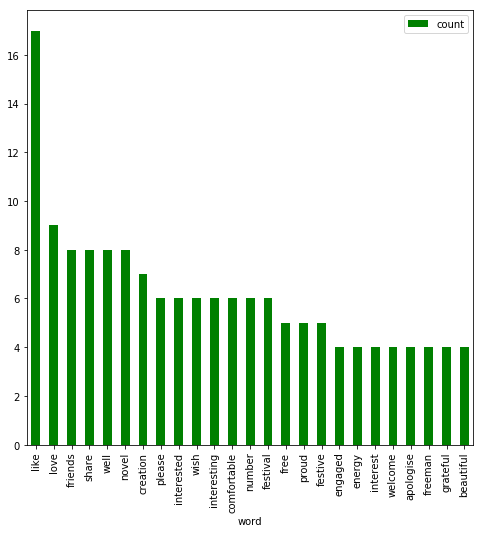

In [43]:
plot_city(data, 'kaliningrad')

#### Kamchatka

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NEGATIVE

               word  count sentiment
32        difficult      2  negative
77            doubt      1  negative
216           avoid      1  negative
217  disappointment      1  negative
219          lowest      1  negative

POSITIVE

            word  count sentiment
11          help      3  positive
20       friends      3  positive
22       support      2  positive
23          best      2  positive
24          want      2  positive
33    interested      2  positive
47     protected      2  positive
48        number      2  positive
59       natural      2  positive
69         truth      1  positive
78           yes      1  positive
79          hope      1  positive
96          like      1  positive
107       desire      1  positive
108         join      1  positive
110        happy      1  positive
112     pleasant      1  positive
113  interesting      1  positive
115         nice      1  positive
117          win      1  positive
136        freed      1  positive
143      

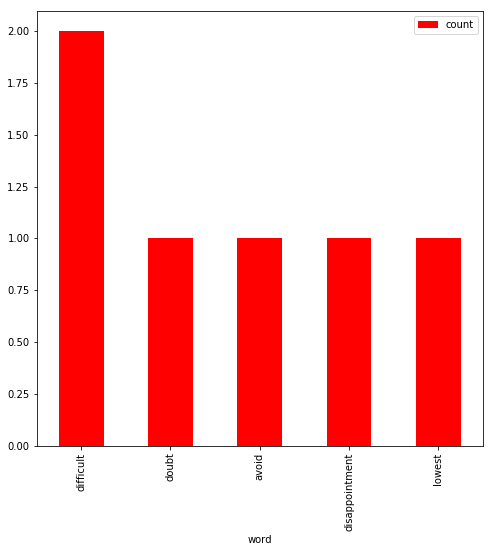

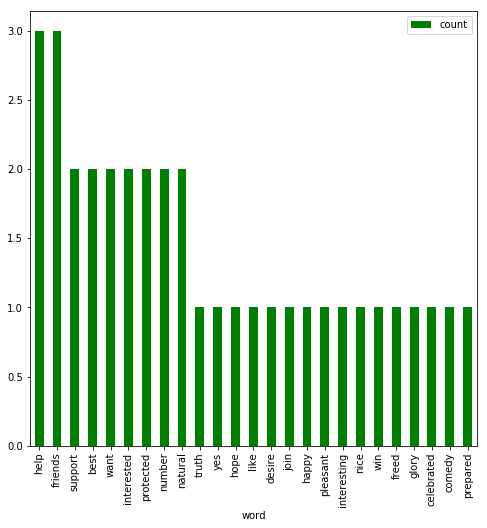

In [44]:
plot_city(data, 'kamchatka')

#### Siberia

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NEGATIVE

         word  count sentiment
70       stop      1  negative
153  fighters      1  negative

POSITIVE

              word  count sentiment
5          friends      4  positive
10            free      4  positive
21       adventure      2  positive
25   championships      2  positive
29         special      2  positive
45           great      1  positive
57            want      1  positive
67            love      1  positive
82           peace      1  positive
92          valued      1  positive
101          truly      1  positive
104      sincerely      1  positive
105           hope      1  positive
106           wise      1  positive
107       solution      1  positive
110           like      1  positive
116        amazing      1  positive
125       rewarded      1  positive
128          greet      1  positive
159         kindly      1  positive


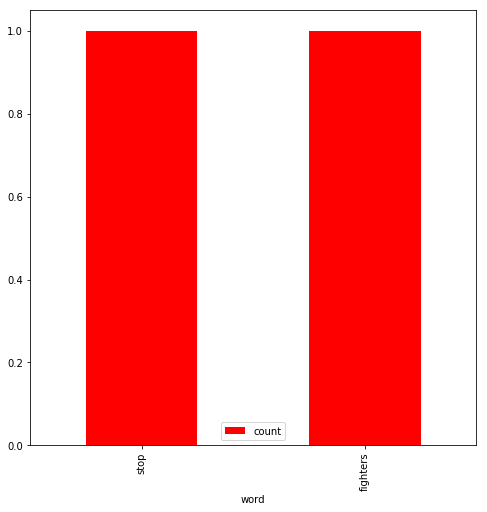

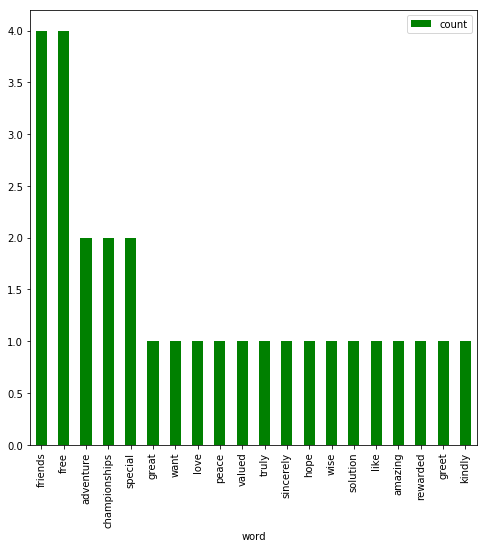

In [45]:
plot_city(data, 'siberia')

#### 3.2.3.3 Other data

In [ ]:
def parse_post_type(data):
    values = data_tmp['type'].values
    types = ['link', 'event', 'note', 'offer', 'photo', 'status', 'video']
    parsed = []
    
    for value in values:
        if not (value in types):
            parsed.append('unknown')
        else:
            parsed.append(value)
    return parsed

In [ ]:
data_tmp = data.copy()
data_tmp['type'] = parse_post_type(data_tmp)

In [ ]:
groups = data_tmp.groupby(['type']).size()
ax = groups.plot(kind = 'bar', grid = True, title = 'Types of posts', figsize=(8, 8))
ax.set_xlabel('Post type');
ax.set_ylabel('Number of posts');

#### 3.3 All together

In [143]:
def get_regions_with_percentage(data_df, city_list):
    output = pd.DataFrame()
    out_dict = dict()
    for city in city_list:
        tmp = filter_by_city(data, city)
        tmp['region'] = city
        output = pd.concat([output, tmp])
    return output

In [167]:
def plot_all(data_df, city_list):
    data = data_df.copy()
    data = get_regions_with_percentage(data_df, city_list)
    data = data.reindex()
    
    hh = pd.crosstab(data['region'], 
                   data['message_sentiment_vader_parsed']).apply(lambda r: r/r.sum() * 100, axis=1)
    
    ax = hh.plot.bar(title = 'Revies sentiments by region', figsize=(8, 8))
    # ax = pd.crosstab(data['region'], 
    #                data['message_sentiment_vader_parsed']).plot.bar(title = 'Revies sentiments by region', figsize=(8, 8))

    ax.set_xlabel('Region');
    ax.set_ylabel('%');

In [168]:
def plot_all2(data_df, city_list):
    data = data_df.copy()
    data = get_regions_with_percentage(data_df, city_list)
    data = data.reindex()
    
    ax = pd.crosstab(data['region'], 
                   data['message_sentiment_vader_parsed']).plot.bar(title = 'Revies sentiments by region', figsize=(8, 8))

    ax.set_xlabel('Region');
    ax.set_ylabel('%');

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


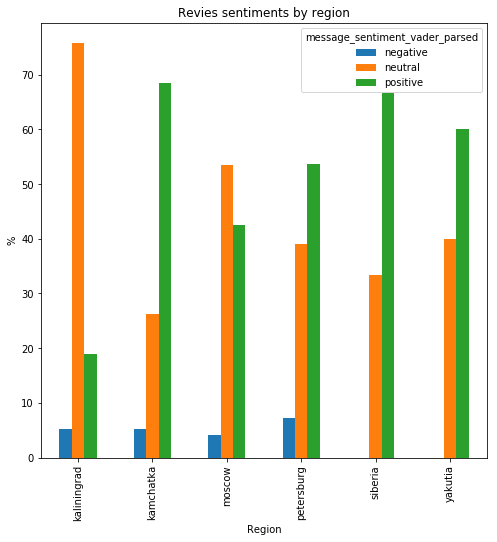

In [169]:
plot_all(data, ['yakutia', 'moscow', 'petersburg', 'kaliningrad', 'kamchatka', 'siberia'])

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


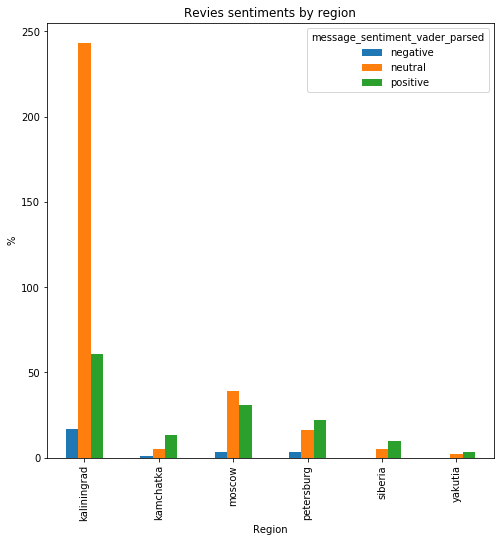

In [170]:
plot_all2(data, ['yakutia', 'moscow', 'petersburg', 'kaliningrad', 'kamchatka', 'siberia'])